## **Project:** 2D Binary Classifier
**Problem:** Classify points in 2D space into two classes (linearly separable).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1. Generate 2D classification data
torch.manual_seed(42)
def generate_data(n_samples=500):
    # Class 0: points around (2, 2)
    X0 = torch.randn(n_samples//2, 2) * 0.8 + torch.tensor([2., 2.])
    y0 = torch.zeros(n_samples//2)

    # Class 1: points around (-2, -1)
    X1 = torch.randn(n_samples//2, 2) * 0.8 + torch.tensor([-2., -1.])
    y1 = torch.ones(n_samples//2)

    X = torch.cat([X0, X1])
    y = torch.cat([y0, y1]).float()  # Binary labels as float for BCE

    return X, y

In [3]:
X, y = generate_data()
print("Data shapes:", X.shape, y.shape)

Data shapes: torch.Size([500, 2]) torch.Size([500])


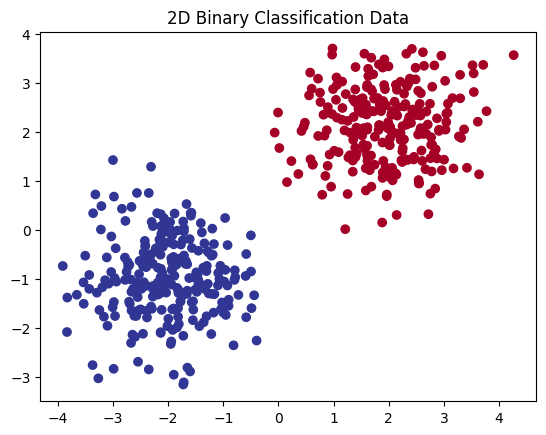

In [4]:
# Visualize
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu')
plt.title("2D Binary Classification Data")
plt.show()

## 2. Dataset + DataLoader

In [5]:
class BinaryDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
# Train/val split
dataset = BinaryDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

## 3. Model: Simple MLP

In [7]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output logits

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No sigmoid! Use BCEWithLogitsLoss
        return x

In [8]:
model = BinaryClassifier()
print("Model params:", sum(p.numel() for p in model.parameters()))

Model params: 65


## 4. Loss + Optimizer + Training Loop

In [9]:
criterion = nn.BCEWithLogitsLoss()  # Handles sigmoid + BCE internally
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [10]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        optimizer.zero_grad()

        logits = model(X_batch)
        loss = criterion(logits.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy
        probs = torch.sigmoid(logits.squeeze())
        preds = (probs > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += len(y_batch)

    return total_loss / len(loader), correct / total

In [11]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(X_batch)
            loss = criterion(logits.squeeze(), y_batch)

            total_loss += loss.item()

            probs = torch.sigmoid(logits.squeeze())
            preds = (probs > 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += len(y_batch)

    return total_loss / len(loader), correct / total

In [12]:
# Training loop
epochs = 100
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d}: Train Loss {train_loss:.3f} Acc {train_acc:.3f} | "
              f"Val Loss {val_loss:.3f} Acc {val_acc:.3f}")

Epoch   0: Train Loss 0.385 Acc 0.885 | Val Loss 0.179 Acc 1.000
Epoch  20: Train Loss 0.006 Acc 1.000 | Val Loss 0.007 Acc 1.000
Epoch  40: Train Loss 0.003 Acc 1.000 | Val Loss 0.003 Acc 1.000
Epoch  60: Train Loss 0.002 Acc 1.000 | Val Loss 0.002 Acc 1.000
Epoch  80: Train Loss 0.001 Acc 1.000 | Val Loss 0.002 Acc 1.000


## 5. Visualize results

In [13]:
# Full dataset predictions
model.eval()
with torch.no_grad():
    all_logits = model(X)
    all_probs = torch.sigmoid(all_logits.squeeze())
    all_preds = (all_probs > 0.5).float()

In [14]:
# Plot decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = torch.meshgrid(
        torch.arange(x_min, x_max, 0.1),
        torch.arange(y_min, y_max, 0.1),
        indexing='xy'
    )
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

    with torch.no_grad():
        probs = torch.sigmoid(model(grid)).squeeze()
        Z = (probs > 0.5).float().reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='k')
    plt.title("Decision Boundary")

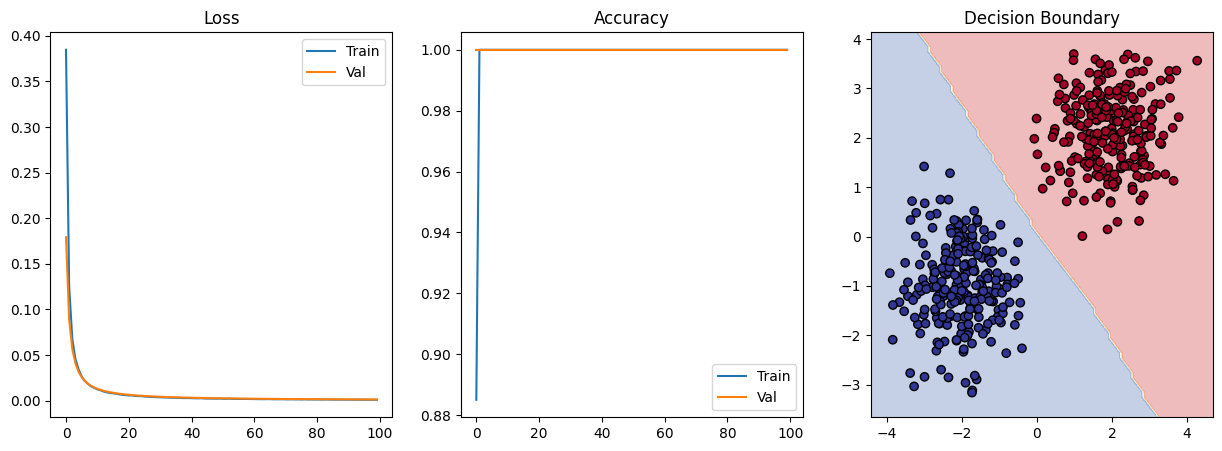

Final Val Accuracy: 1.000


In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend()
plt.title('Loss')
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 3, 3)
plot_decision_boundary(model, X, y)
plt.show()

print(f"Final Val Accuracy: {val_accs[-1]:.3f}")

## 6. Save and load model

In [16]:
# Save
torch.save(model.state_dict(), 'binary_classifier.pt')
print("Model saved!")

Model saved!


In [17]:
# Load (to test)
new_model = BinaryClassifier()
new_model.load_state_dict(torch.load('binary_classifier.pt'))
new_model.eval()
print("Model loaded successfully!")

Model loaded successfully!
